
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BACS module
from bacs.agents.bacs import BACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "Maze10-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
DO_GA = True
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BACS Set Up
DO_ZIP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ □ ■ ■ ■ ■ ■
■ A ■ $ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BACS - Exploration

In [4]:
%%time
#%%prun -l 0.5 -T profiling.txt

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 3min 33s, sys: 1.43 s, total: 3min 34s
Wall time: 4min 10s


### Performance

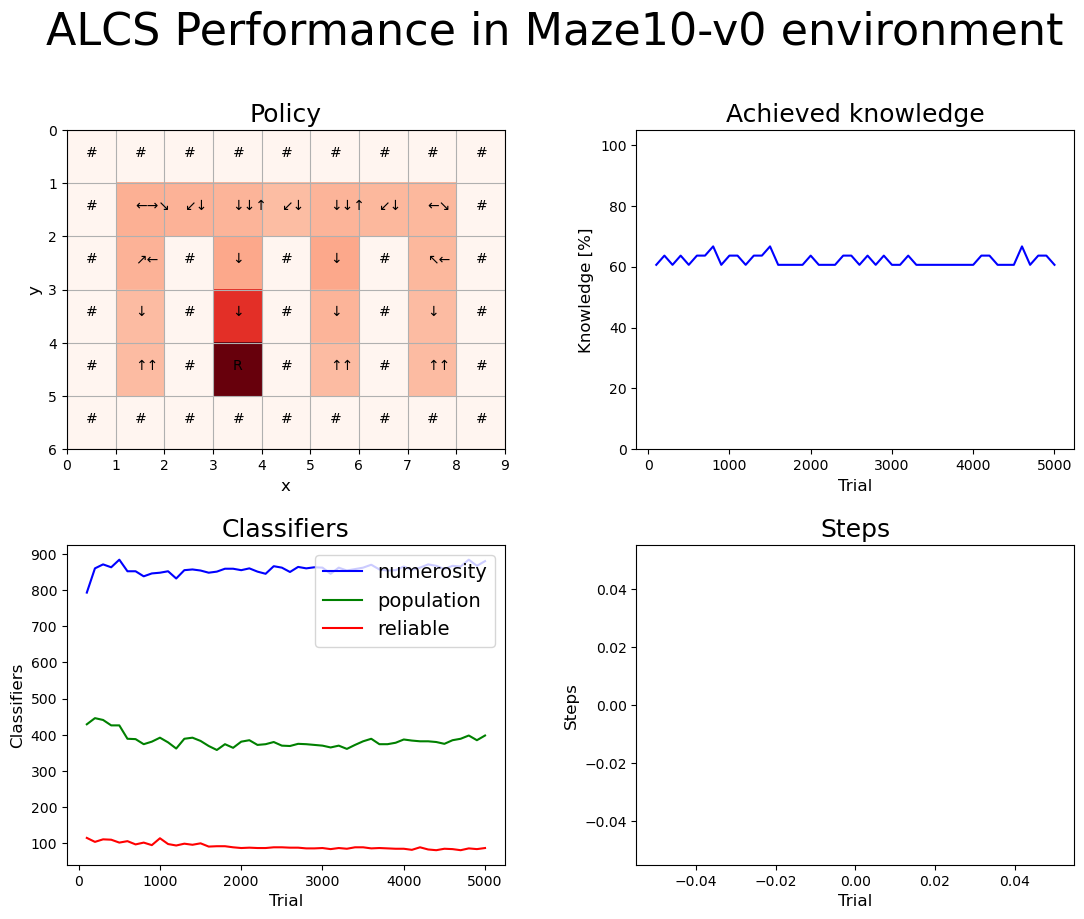

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
{'knowledge': 60.60606060606061, 'population': 398, 'numerosity': 880, 'reliable': 87}
Mean reliable population specifity is  (0.507183908045977, 0.29605263157894735, 0.6709183673469388)
Accumulated Error on PEP Probabilities : 0.8854166666666666 %

{'knowledge': 60.60606060606061, 'population': 147, 'numerosity': 621, 'reliable': 63}
Mean reliable population specifity is  (0.4503968253968254, 0.26136363636363635, 0.6583333333333333)
Accumulated Error on PEP Probabilities : 0.8854166666666666 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

####9### 4 None ####1###
q: 1.0    r: 1e+03  ir: 1e+03  f: 1e+03  
exp: 3404  num: 20
Mark: empty
tga: 240065 talp: 240096 tav: 75.06  



0####### 6 None ########
q: 1.0    r: 489.3  ir: 0.0    f: 489.3  
exp: 4559  num: 12
Mark: empty
tga: 240084 talp: 240084 tav: 73.7   



######1# 6 None ########
q: 1.0    r: 489.1  ir: 0.0    f: 489.1  
exp: 4639  num: 8
Mark: empty
tga: 240084 talp: 240084 tav: 73.55  



#1###### 1 None ########
q: 1.0    r: 480.5  ir: 0.0    f: 480.5  
exp: 2771  num: 19
Mark: empty
tga: 239995 talp: 240090 tav: 77.63  



##1##### 2 None ########
q: 1.0    r: 466.4  ir: 0.0    f: 466.4  
exp: 3165  num: 19
Mark: empty
tga: 240017 talp: 240017 tav: 78.65  



#0##0##0 4 None #1##9##1
q: 0.7771 r: 588.9  ir: 0.0    f: 457.7  
exp: 6073  num: 1
Mark: 00110110
tga: 240002 talp: 240096 tav: 15.97  



###1#### 3 None ########
q: 1.0    r: 456.9  ir: 0.0    f: 456.9  
exp: 3783  num: 20
Mark: empty
tga: 240089 talp: 240089 tav: 66.93  



#####1## 5 None ########
q

## Training of BACS - Exploitation

In [8]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    epsilon=0.2
)

agent_exploit_no_rl = BACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 10.5 s, sys: 75.8 ms, total: 10.6 s
Wall time: 12.1 s


In [9]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    epsilon=0.0
)

agent_exploit_rl_start = BACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 11.1 s, sys: 86.1 ms, total: 11.2 s
Wall time: 13.4 s


In [10]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
)

agent_exploit_rl = BACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 12.4 s, sys: 123 ms, total: 12.5 s
Wall time: 17.4 s


### Performance

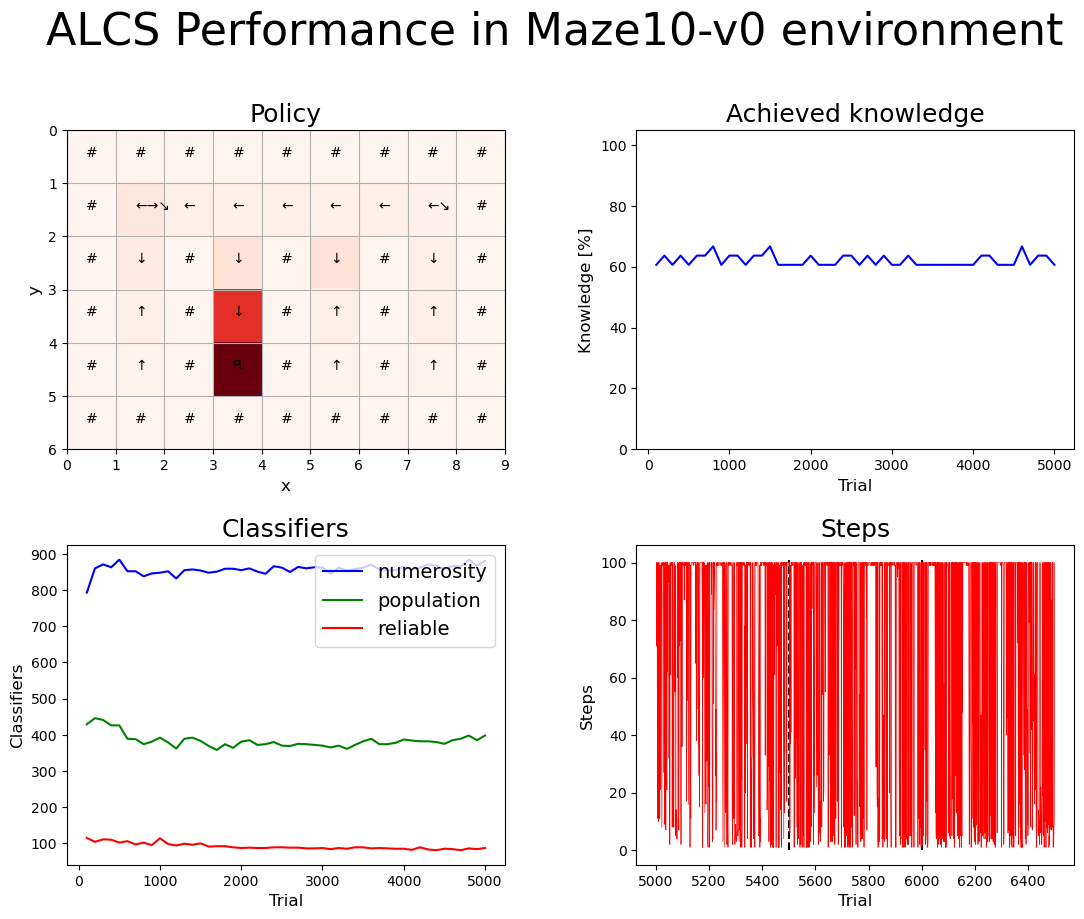

In [11]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [12]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  49.18  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  70.642  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  68.174  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  61.41  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 60.60606060606061, 'population': 147, 'numerosity': 621, 'reliable': 63}
{'knowledge': 60.60606060606061, 'population': 147, 'numerosity': 621, 'reliable': 63}
{'knowledge': 60.60606060606061, 'population': 147, 'numerosity': 621, 'reliable': 63}
{'knowledge': 60.60606060606061, 'population': 147, 'numerosity': 621, 'reliable': 63}


In [13]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl
    if cl.does_match("01110111")]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

21


0####### 6 None ########
q: 1.0    r: 489.3  ir: 0.0    f: 489.3  
exp: 4559  num: 12
Mark: empty
tga: 240084 talp: 240084 tav: 73.7   



######1# 6 None ########
q: 1.0    r: 489.1  ir: 0.0    f: 489.1  
exp: 4639  num: 8
Mark: empty
tga: 240084 talp: 240084 tav: 73.55  



#1###### 1 None ########
q: 1.0    r: 480.5  ir: 0.0    f: 480.5  
exp: 2771  num: 19
Mark: empty
tga: 239995 talp: 240090 tav: 77.63  



##1##### 2 None ########
q: 1.0    r: 466.4  ir: 0.0    f: 466.4  
exp: 3165  num: 19
Mark: empty
tga: 240017 talp: 240017 tav: 78.65  



###1#### 3 None ########
q: 1.0    r: 456.9  ir: 0.0    f: 456.9  
exp: 3783  num: 20
Mark: empty
tga: 240089 talp: 240089 tav: 66.93  



#####1## 5 None ########
q: 1.0    r: 435.8  ir: 0.0    f: 435.8  
exp: 3508  num: 20
Mark: empty
tga: 239957 talp: 240048 tav: 67.48  



#######1 7 None ########
q: 1.0    r: 411.2  ir: 0.0    f: 411.2  
exp: 2760  num: 20
Mark: empty
tga: 240016 talp: 240083 tav: 81.59  



011#0#11 0 None #0#####